# Quantum Finance Application on Arbitrage Opportunity Optimization

<em> Copyright (c) 2021 Institute for Quantum Computing, Baidu Inc. All Rights Reserved. </em>

## Overview

Current finance problems can be mainly tackled by three areas of quantum algorithms: quantum simulation, quantum optimization, and quantum machine learning [1,2]. Many financial problems are essentially combinatorial optimization problems, and corresponding algorithms usually have high time complexity and are difficult to implement. Due to the power of quantum computing, these complex problems are expected to be solved by quantum algorithms in the future.

The Quantum Finance module of Paddle Quantum focuses on quantum optimization: how to apply quantum algorithms in real finance optimization problems. This tutorial focuses on how to use quantum algorithms to solve the arbitrage opportunity optimization problem [3].


## Arbitrage Opportunity Optimization 

Arbitrage describes the fact that the same asset has different prices in different markets and can be traded between multiple markets to generate a positive return. That is, given a set of assets and transaction costs, it is possible to have a cycle among different markets that can generate a positive return.

This problem can be formulated in the language of graph theory: given a weighted directed graph $G$ with vertex $i$ denoting $i$ th market currency, the weight of the edge from vertex $i$ to vertex $j$ denoting the exchange rate $c_{ij} $ that converts currency $i$ to currency $j$. That is if we have a currency $i$ of quantity $x_i$, then by the exchange rate, we will get a currency $j$ of quantity $c_{ij}x_i$. In general, the exchange rate is not symmetric, i.e. $c_{ij} \neq c_{ji}$. We also assume that transaction costs (service fees etc.) are already included in the exchange rate.

Given the number of tradable currency types $n$, the optimization problem is to find a cycle of the maximal profit on the given directed graph with $K (K \leq n)$ vertices. In this finance module, users can define the number of vertices contained in the arbitrage cycle $K$ according to their requirements.


### Encoding Arbitrage Opportunity Optimization Problem

To transform the arbitrage opportunity optimization problem into a problem applicable for parameterized quantum circuits, we need to encode the arbitrage opportunity optimization problem into a Hamiltonian. We realize the encoding by first constructing an integer programming problem. Suppose there are $|V|=n$ vertices in graph $G$. Then for each vertex $i \in V$, we define $n$ binary variables $x_{i,k}$, where $k \in [0,K-1]$, such that

$$
x_{i, k}=
\begin{cases}
1, & \text{the order of traded to vertex } i \text { in the arbitrage cycle is $k$}\\
0, & \text{otherwise}
\end{cases}.
\tag{1}
$$

Refering to the Travelling Salesman Problem ([TSP tutorial](./TSP_CN.ipynb)), since $G$ has $n$ vertices, we have $n^2$ variables in total, whose value we denote by a bit string $x=x_{0,0}x_{0,1}\dots x_{n-1,K-1}$. Assume for now that the bit string $x$ represents a arbitrage cycle. Then for each edge $(i,j,w_{i,j}) \in E$, we will have $x_{i,k} = x_{j,k+1}=1$, i.e., $x_{i,k}\cdot x_{j,k+1}=1$, if and only if the arbitrage cycle visits vertex $i$ at time $k$ and vertex $j$ at time $k+1$. Otherwise, $x_{i,k}\cdot x_{j,k+1}$ will be $0$. Therefore the logarithm of the profit of the cycle is:

$$
P(x) = - \sum_{i,j\in V} \log(c_{ij}) \sum_{k=0}^{K-1}  x_{i,k}x_{j,k+1}, \tag{2}
$$

For $x$ to represent a valid arbitrage cycle, the following constraint needs to be met:

$$
\sum_{i=0}^{n-1} x_{i,k} = 1 \quad \text{and} \quad \sum_{k=0}^{K-1}\sum_{(i,j)\notin E}x_{i,k}x_{j, k+1}, \tag{3}
$$

where the first equation guarantees that only one vertex is visited at each time $k$. The second term constrains that a nonexistent edge does not appear in the found arbitrage cycle. These two equations ensure that the parameterized quantum circuits find $𝑥$ as a simple loop. Then the cost function under the constraint can be formulated below:
$$
C_x = - P(x) + A\sum_{k=0}^{K-1} \left(1 - \sum_{i=0}^{n-1} x_{i,k}\right)^2 + A\sum_{k=0}^{K-1}\sum_{(i,j)\notin E}
x_{i,k}x_{j,k+1}.
\tag{4}
$$
In this equation, $V$ is the number of vertices of the graph, $E$ is the edge set of the graph and $K$ is the number of vertices of the most profitable cycle. Note that as we would like to maximize the $P(x)$ while ensuring $x$ represents a valid arbitrage cycle, we had better set $A$ large, at least larger than the largest weight of edges.

We now need to transform the cost function $C_x$ into a Hamiltonian to realize the encoding of the arbitrage opportunity optimization problem. Each variable $x_{i,k}$ has two possible values, $0$ and $1$, corresponding to quantum states $|0\rangle$ and $|1\rangle$. Note that every variable corresponds to a qubit and so $n^2$ qubits are needed for solving the arbitrage opportunity optimization problem. The Pauli $Z$ operator has two eigenstates, $|0\rangle$ and $|1\rangle$ . Their corresponding eigenvalues are 1 and -1, respectively. So we consider encoding the cost function as a Hamiltonian using the Pauli $Z$ matrix.

Now we would like to consider the mapping
$$
x_{i,k} \mapsto \frac{I-Z_{i,k}}{2}, \tag{3}
$$

where $Z_{i,k} = I \otimes I \otimes \ldots \otimes Z \otimes \ldots \otimes I$ with $Z$ operates on the qubit at position $(i,k)$. Under this mapping, the value of $x_{i,k}$ can be illustrated in a different way. If the qubit $(i,k)$ is in state $|1\rangle$, then $x_{i,k} |1\rangle = \frac{I-Z_{i,k}}{2} |1\rangle = 1|1\rangle $, which means vertex $i$ is visited at time $k$. Also, for the qubit $(i,k)$ in state $|0\rangle$, $x_{i,k}|0\rangle  = \frac{I-Z_{i,k}}{2} |0\rangle = 0 |0\rangle $.

Thus using the above mapping, we can transform the cost function $C_x$ into a Hamiltonian $H_C$ for the system of $n^2$ qubits and realize the quantumization of the arbitrage opportunity optimization problem. Then the ground state of $H_C$ is the optimal solution to the arbitrage opportunity optimization problem. In the following section, we will show how to use a parameterized quantum circuit to find the ground state, i.e., the eigenvector with the smallest eigenvalue.

## Paddle Quantum Implementation

To investigate the arbitrage opportunity optimization problem using Paddle Quantum, there are some required packages to import, which are shown below. The ``networkx`` package is the tool to handle graphs.

In [1]:
# Import packages needed
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Import related modules from Paddle Quantum and PaddlePaddle
import paddle
import paddle_quantum
from paddle_quantum.ansatz import Circuit
from paddle_quantum.finance  import arbitrage_opportunities_hamiltonian

Next, we generate a weighted directed graph $G$ with $3$ vertices.  For the convenience of computation, the vertices here are labeled starting from $0$.

At the same time, in order to verify the solution more easily, special values are assigned for the weights in the directed graph. In practice, users can construct their own desired graphs and set the real exchange rates.

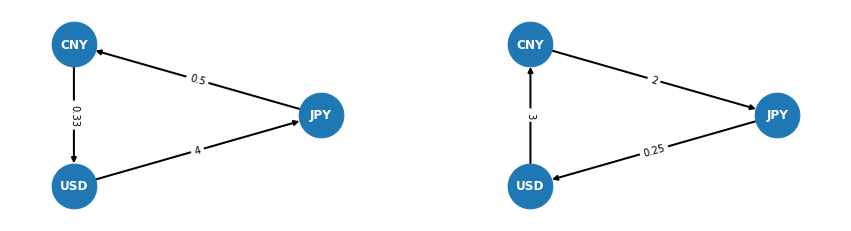

In [2]:
# n is the number of vertices in the graph G
n = 3
nodes = [ "JPY", "CNY", "USD"]
G = nx.DiGraph()
G.add_nodes_from(nodes)
edges = [("JPY","CNY", 0.5), ("CNY","JPY",2), ("CNY","USD", 0.33), ("USD","CNY",3),("JPY","USD", 0.25), ("USD","JPY",4)]
G.add_weighted_edges_from(edges)

# The two graphs represent the exchange rates in different directions
G1 = nx.DiGraph()
G1.add_nodes_from(nodes)
edges1 = [("JPY","CNY", 0.5),  ("CNY","USD", 0.33), ("USD","JPY",4)]
G1.add_weighted_edges_from(edges1)

G2 = nx.DiGraph()
G2.add_nodes_from(nodes)
edges2 = [("CNY","JPY",2), ("USD","CNY",3),("JPY","USD", 0.25)]
G2.add_weighted_edges_from(edges2)


options = {
    "with_labels": True,
    "font_weight": "bold",
    "font_color": "white",
    "node_size": 2000,
    "width": 2
}
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
for i, a in enumerate(ax):
    a.axis('off')
    a.margins(0.20)
nx.draw(G1, pos=nx.circular_layout(G1), ax=ax[0], **options)
nx.drawing.nx_pylab.draw_networkx_edge_labels(G1, pos=nx.circular_layout(G1), ax=ax[0], edge_labels=nx.get_edge_attributes(G1, 'weight'))
nx.draw(G2, pos=nx.circular_layout(G2), ax=ax[1], **options)
nx.drawing.nx_pylab.draw_networkx_edge_labels(G2, pos=nx.circular_layout(G2), ax=ax[1], edge_labels=nx.get_edge_attributes(G2, 'weight'))
plt.axis("off")
plt.show()

### Encoding Hamiltonian

Here we construct the Hamiltonian $H_C$ of Eq. (4) with the replacement in Eq. (5). 


In [3]:
# Penalty parameter: in this case, it is equal to the maximum weight of the edges in the directed graph
penalty = 4 
# In this example, all currency types are selected within the transaction cycle
K = n
# Construct the Hamiltonian of arbitrage opportunity optimization
hamiltonian = arbitrage_opportunities_hamiltonian(G, penalty, n, K)

### Calculating the loss function 

We adopt a parameterized quantum circuit consisting of $U_3(\vec{\theta})$ and $\text{CNOT}$ gates, that can be done by calling the built-in method [`complex_entangled_layer()`](https://qml.baidu.com/api/paddle_quantum.ansatz.circuit.html#Circuit.complex_entangled_layer).

After running the quantum circuit, we obtain the output circuit $|\vec{\theta
}\rangle$. From the output state of the circuit, we can define the loss function of the arbitrage opportunity optimization under the classical-quantum hybrid model:

$$
L(\vec{\theta}) =  \langle\vec{\theta}|H_C|\vec{\theta}\rangle.
\tag{6}
$$

We then use a classical optimization algorithm to minimize this function and find the optimal parameters $\vec{\theta}^*$. The following code shows a complete network built with Paddle Quantum and PaddlePaddle.

In [11]:
class AONet(paddle.nn.Layer):
    def __init__(self, num_qubits, p, dtype="float64"):
        super(AONet, self).__init__()

        self.depth = p
        self.num_qubits = num_qubits
        self.cir = Circuit(self.num_qubits)
        self.cir.complex_entangled_layer(depth=self.depth)

    def forward(self):
        """
        Forward propagation
        """
        # Run the quantum circuit
        state = self.cir(init_state)
        # Calculate the loss function
        loss = loss_func(state)

        return loss, self.cir

### Training the quantum neural network

After defining the quantum neural network, we use the gradient descent method to update the parameters to minimize the expectation value in Eq. (6). 

In [13]:
SEED = 100   # Set a global RNG seed 
p = 1        # Number of layers in the quantum circuit
ITR = 120    # Number of training iterations
LR = 0.4     # Learning rate of the optimization method based on gradient descent

Here, we optimize the network defined above in PaddlePaddle.

In [16]:
# Fix paddle random seed
paddle.seed(SEED)
# define the number of qubits need for circuit
num_qubits = n * K
# Building Quantum Neural Networks
net = AONet(num_qubits, p)
# Define initial state
init_state = paddle_quantum.state.zero_state(num_qubits)
# Use Adam optimizer
opt = paddle.optimizer.Adam(learning_rate=LR, parameters=net.parameters())
# define loss function
loss_func = paddle_quantum.loss.ExpecVal(hamiltonian)
# Gradient descent iteration
for itr in range(1, ITR + 1):
    # Run the network defined above
    loss, cir = net()
    # Calculate the gradient and optimize
    loss.backward()
    opt.minimize(loss)
    opt.clear_grad()
    if itr % 10 == 0:
        print("iter: ", itr, "    loss: ", "%.4f"% loss.numpy())

iter:  10     loss:  0.4704
iter:  20     loss:  0.1302
iter:  30     loss:  -0.2744
iter:  40     loss:  -0.4700
iter:  50     loss:  -0.5512
iter:  60     loss:  -0.5684
iter:  70     loss:  -0.5821
iter:  80     loss:  -0.5833
iter:  90     loss:  -0.5843
iter:  100     loss:  -0.5847
iter:  110     loss:  -0.5849
iter:  120     loss:  -0.5849


### Decoding the quantum solution

After obtaining the minimum value of the loss function and the corresponding set of parameters $\vec{\theta}^*$, our task has not been completed. In order to obtain an approximate solution to the arbitrage opportunity optimization problem, it is necessary to decode the solution to the classical optimization problem from the quantum state $|\vec{\theta}^*\rangle$ output by the circuit. To decode a quantum state, we need to measure it and then calculate the probability distribution of the measurement results, where a measurement result is a bit string that represents an answer for the arbitrage opportunity optimization problem: 

$$
p(z) = |\langle z|\vec{\theta}^*\rangle|^2.
\tag{6}
$$

In the case of quantum parameterized circuits with sufficient expressiveness, the greater the probability of a certain bit string is, the greater the probability that it corresponds to an optimal solution of the arbitrage opportunity optimization problem.

Paddle Quantum provides a function to read the probability distribution of the measurement results of the state output by the quantum circuit:

In [17]:
# Repeat the simulated measurement of the circuit output state 1024 times
final_state = cir(init_state)
prob_measure = final_state.measure(shots=1024)
arbitrage_opportunity_route = max(prob_measure, key=prob_measure.get)
print("The bit string form of the solution:", arbitrage_opportunity_route)

The bit string form of the solution: 100001010


After measurement, we have found the bit string with the highest probability of occurrence, i.e. the most profitable cycle in the form of the bit string. The binary strings are grouped every $n$ bits, and $1$ appearing at the $k$th bit in each group indicates the order that the asset is traded into this market. If the result is not valid as explained before, users can get better training results by adjusting parameters such as the random seed ``SEED``, the number of layers of the quantum circuit ``p``, the number of iterations ``ITR`` and the gradient descent optimization rate ``LR``.

The following code maps the bit string back to the classic solution in the form of `dictionary`, where the `key` represents the vertex currency and the `value` represents its order, i.e. when the asset is traded into this market.

Also, we calculated the positive return of the asset after the optimal arbitrage cycle.

In [18]:
solution = {nodes[i]:t for i in range(n) for t in range(n) if arbitrage_opportunity_route[i * n + t] == '1'}
print(solution)
rate = sum([np.log2(G[u][v]["weight"]) if solution[v] == (solution[u] + 1) % n else 0 for (u, v) in G.edges])
print("Positive return rate: ", 2**rate)

{'JPY': 0, 'CNY': 2, 'USD': 1}
Positive return rate:  1.5


In order to clearly represent the most profitable cycle of the assets, a graphical representation is still chosen:
* The numbers in the vertices represent the order of the transaction to this market and the letters represent currencies

* The red edges represent the found optimal route.

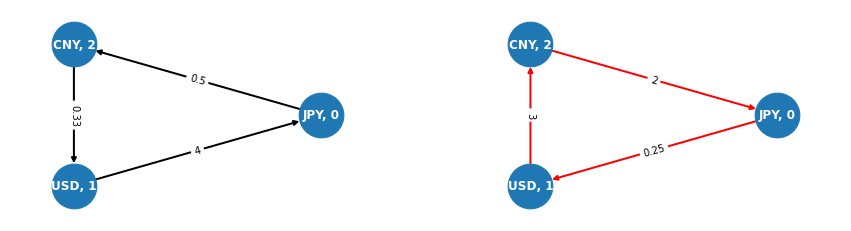

In [19]:
label_dict = {i: str(i) + ", " + str(t) for i, t in solution.items()}
edge_color1 = ["red" if solution[v] == (solution[u] + 1) % n else "black"
              for (u, v) in G1.edges]
edge_color2 = ["red" if solution[v] == (solution[u] + 1) % n else "black"
              for (u, v) in G2.edges]

# Draw the optimal arbitrage cycle on the graph
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
for i, a in enumerate(ax):
    a.axis('off')
    a.margins(0.20)
nx.draw(G1, pos=nx.circular_layout(G1), labels=label_dict, edge_color=edge_color1, ax=ax[0], **options)
nx.drawing.nx_pylab.draw_networkx_edge_labels(G1, pos=nx.circular_layout(G1), ax=ax[0], edge_labels=nx.get_edge_attributes(G1, 'weight'))
nx.draw(G2, pos=nx.circular_layout(G2), labels=label_dict, edge_color=edge_color2, ax=ax[1], **options)
nx.drawing.nx_pylab.draw_networkx_edge_labels(G2, pos=nx.circular_layout(G2), ax=ax[1], edge_labels=nx.get_edge_attributes(G2, 'weight'))
plt.axis("off")
plt.show()

The left graph given above shows the edge that is not in the arbitrage cycle, and the right graph shows the optimal solution found by the algorithm.

### Conclusion

In this tutorial, we provide a way to approximate a cycle of transactions with the maximum positive return in the arbitrage opportunity problem. For $n$ currencies, we need to use $n^2$ qubits for the optimization. We assign special values to exchange rates for testing, and users can assign those values themselves, i.e. according to the current market.

In real financial markets, high return as $1.5$ in this tutorial on arbitrage is not usually available. Also, the number of currencies considered would be large with more influencing factors. This would be hard to implement. 

_______

## References

[1] Orus, Roman, Samuel Mugel, and Enrique Lizaso. "Quantum computing for finance: Overview and prospects." [Reviews in Physics 4 (2019): 100028.](https://arxiv.org/abs/1807.03890)

[2] Egger, Daniel J., et al. "Quantum computing for Finance: state of the art and future prospects." [IEEE Transactions on Quantum Engineering (2020).](https://arxiv.org/abs/2006.14510)

[3] Rosenberg, G. "Finding optimal arbitrage opportunities using a quantum annealer." [1QB Information Technologies Write Paper (2016): 1-7.](https://1qbit.com/whitepaper/arbitrage/)